# Introduction

This notebook is purely for development. When we want to create a new model, we just use this notebook, pull in data from somewhere (ideally generated from our `simulator`) and train a model. 

When we finish, we will convert this notebook to a script, that we execute (reading data from the same file, training the model, etc) as soon as the docker container starts. The file dumps a model that our server.py loads and uses to perform predictions against data coming in via POST requests from our simulator.

In [161]:
import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf 
import csv
import json

## Loading our data

In [162]:
!head readings.csv

reading_type,reading
normal,"[3.351600230178196, 3.4192233870403532, 3.4867716922342296, 3.5542239082609455, 3.6215587954986295, 3.688755123593989, 3.7557916828538644, 3.8226472956299555, 3.889300827689874, 3.955731199567716, 4.02191739788735, 4.087838486651604, 4.153473618490594, 4.218802045862439, 4.283803132199623, 4.34845636299431, 4.412741356815967, 4.476637876254646, 4.540125838783375, 4.603185327533101, 4.665796601973718, 4.727940108494756, 4.789596490879365, 4.850746600665283, 4.911371507386572, 4.971452508689936, 5.03097114031956, 5.089909185964439, 5.14824868696227, 5.205971951854103, 5.263061565783933, 5.3195003997376595, 5.375271619615784, 5.430358695134424, 5.484745408549281, 5.538415863197317, 5.591354491850996, 5.643546064880076, 5.6949756982160435, 5.7456288611144055, 5.795491383710178, 5.844549464362028, 5.892789676780684, 5.940198976937312, 5.98676470974773, 6.0324746155284705, 6.077316836220801, 6.121279921379006, 6.164352833919331, 6.206524955626192, 6.2477860924123

In [163]:
def load_data(filename): 
    """
    Load our .csv file
    returns two arrays, one for the time-steps
    and the second for the actual readings at those steps.
    """
    time_steps = []
    amplitudes = []
    with open(filename, mode='r') as file: 
        csv_reader = csv.reader(file, delimiter=',')
        next(csv_reader)
        for row in csv_reader: 
            raw_list = json.loads(row[1])
            for i, value in enumerate(raw_list): 
                amplitudes.append(value)
                time_steps.append(i)
            # we're only reading one row so we break here. 
            break 
    time = np.array(time_steps)
    amps = np.array(amplitudes)
    return time, amps
time, series = load_data("readings.csv")

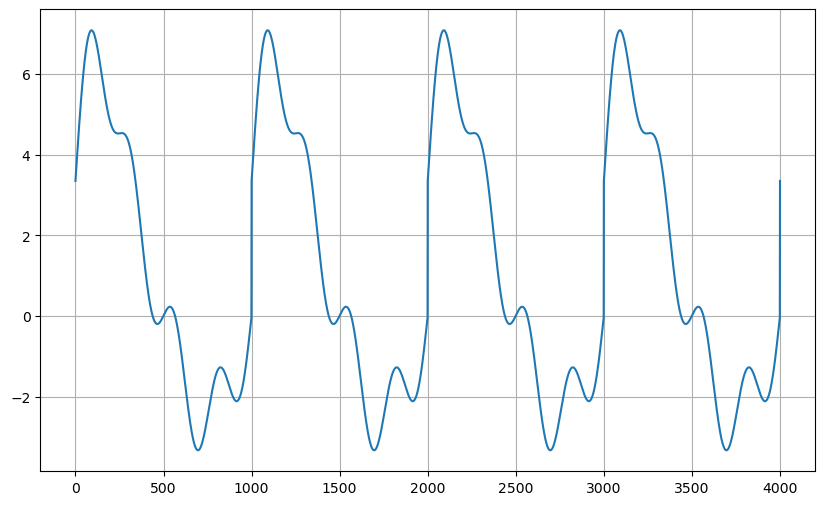

In [164]:
def plot_values(debug=False, series=None): 
    if debug == True: 
        plt.plot(series, label="time values")
        plt.show()

def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None): 
    plt.figure(figsize=(10, 6))
    if type(y) is tuple: 
        for y_curr in y: 
            plt.plot(x[start:end], y_curr[start:end], format)
    else: 
        plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend: 
        plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_series(time, series)

## Splitting our dataset

Here we start to split our dataset into train and validation sets. We'll follow through with building out windows of these datasets to pass into a tuning model, so as to find our optimal learning rate.

In [165]:
split_time = 3000 # out of a 4k long list of values.
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

print(f"time validation set shape: {time_valid.shape}")
print(f"time train set shape: {time_train.shape}")


time validation set shape: (1001,)
time train set shape: (3000,)


#### Buffering our window sizes. 

In [166]:
def window(series, window_size, batch_size, shuffle_buffer): 
    dataset = tf.data.Dataset.from_tensor_slices(series) # create the dataset frame
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # build out windows of a set size and shift by one for each 
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # batches each window into concrete arrays
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache().prefetch(1)
    return dataset

In [167]:
window_size = 30 
batch_size = 32 
shuffle = 1000
train_set = window(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle)

### Building our tuning model 

In [168]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)), 
    tf.keras.layers.Dense(30, activation="relu"), 
    tf.keras.layers.Dense(30, activation="relu"), 
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,891
Trainable params: 1,891
Non-trainable params: 0
_________________________________________________________________


In [169]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20 ))
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


2025-05-28 22:34:50.948186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3000]
	 [[{{node Placeholder/_0}}]]
2025-05-28 22:34:50.948375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3000]
	 [[{{node Placeholder/_0}}]]


93/93 [==============================] - 0s 2ms/step - loss: 3.5786 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 0s 378us/step - loss: 3.5784 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 0s 386us/step - loss: 3.5782 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 0s 374us/step - loss: 3.5779 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 0s 380us/step - loss: 3.5776 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 0s 372us/step - loss: 3.5773 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 0s 382us/step - loss: 3.5769 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 0s 359us/step - loss: 3.5765 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 0s 383us/step - loss: 3.5760 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 0s 366us/step - loss: 3.5754 - lr: 2.8184e-08
Epoch 11/100
93/93 [===

(1e-08, 0.001, 0.0, 100.0)

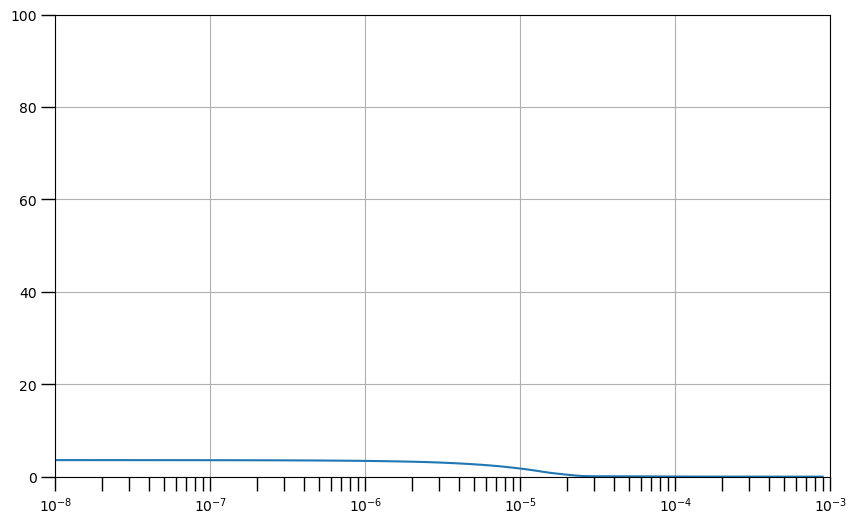

In [170]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history['loss'])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 100])

#### Train a new model 

In [171]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)), 
    tf.keras.layers.Dense(30, activation='relu'), 
    tf.keras.layers.Dense(30, activation='relu'), 
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,891
Trainable params: 1,891
Non-trainable params: 0
_________________________________________________________________


In [172]:
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=30)

Epoch 1/30
93/93 [==============================] - 0s 522us/step - loss: 1.2919 - mae: 1.6320
Epoch 2/30
93/93 [==============================] - 0s 505us/step - loss: 0.0859 - mae: 0.2629
Epoch 3/30
93/93 [==============================] - 0s 407us/step - loss: 0.0594 - mae: 0.2027
Epoch 4/30
93/93 [==============================] - 0s 409us/step - loss: 0.0474 - mae: 0.1670
Epoch 5/30
93/93 [==============================] - 0s 427us/step - loss: 0.0370 - mae: 0.1312
Epoch 6/30
93/93 [==============================] - 0s 406us/step - loss: 0.0271 - mae: 0.0950
Epoch 7/30
93/93 [==============================] - 0s 415us/step - loss: 0.0222 - mae: 0.0786
Epoch 8/30
93/93 [==============================] - 0s 394us/step - loss: 0.0181 - mae: 0.0621
Epoch 9/30
93/93 [==============================] - 0s 385us/step - loss: 0.0153 - mae: 0.0504
Epoch 10/30
93/93 [==============================] - 0s 395us/step - loss: 0.0136 - mae: 0.0477
Epoch 11/30
93/93 [==============================

### Build out the model predictions

In [173]:
def model_forecast(model, series, window_size, batch_size): 
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset, verbose=0)
    return forecast

2025-05-28 22:34:56.448374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1030]
	 [[{{node Placeholder/_0}}]]
2025-05-28 22:34:56.448509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1030]
	 [[{{node Placeholder/_0}}]]


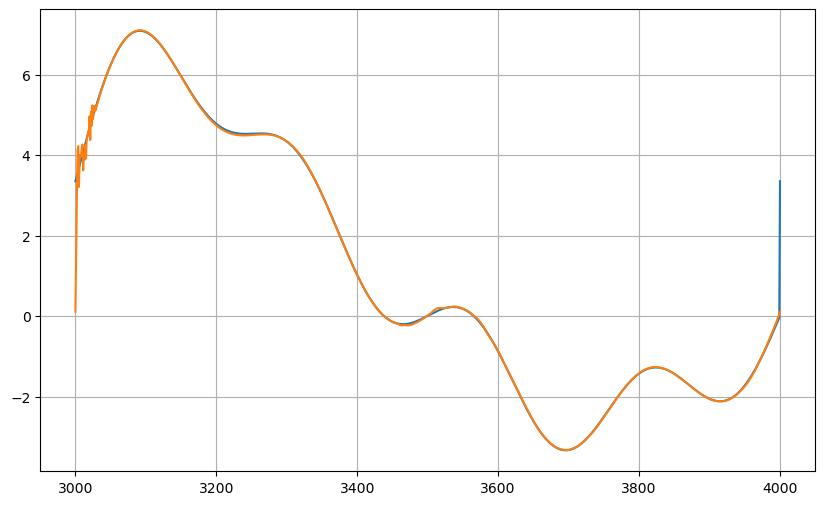

In [174]:
forecast_series = series[split_time - window_size: - 1] # get the forecast series for the "validation set"
forecast = model_forecast(
    model, forecast_series, window_size, 
    batch_size) 
results = forecast.squeeze() 
plot_series(time_valid, (x_valid, results))

In [175]:
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

0.027349899
0.028093398


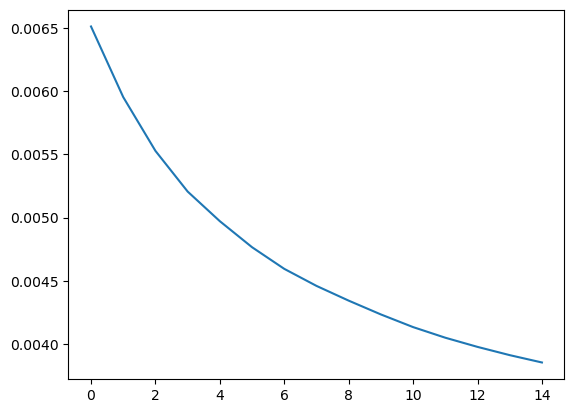

In [179]:
loss = history.history['loss']
loss = loss[15:]
plt.plot(loss)
plt.show()